import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
## Machine Learning: Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pylab as pl
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint
warnings.filterwarnings('ignore')
linkname = 'bank_cleaned.csv'
dataset = pd.read_csv(linkname)
dataset = dataset.drop(['Unnamed: 0'], axis=1)
term_deposit = dataset.copy()

In [2]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,response_binary,month_int,age_group,balance_group
0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,0,5.0,50.0,average balance
1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,0,5.0,40.0,low balance
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,0,5.0,30.0,low balance
3,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,0,5.0,30.0,low balance
4,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,0,5.0,20.0,low balance


### Prepare Data for Classification

In [3]:
dataset.drop(['marital', 'education', 'balance_group', 'response_binary'],axis=1)

,age,job,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,month_int,age_group
0,58,management,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,5.0,50.0
1,44,technician,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,5.0,40.0
2,33,entrepreneur,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,5.0,30.0
3,35,management,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,5.0,30.0
4,28,management,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,5.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40836,25,technician,no,505,no,yes,17,nov,6.43,2,-1,0,unknown,yes,11.0,20.0
40837,51,technician,no,825,no,no,17,nov,16.28,3,-1,0,unknown,yes,11.0,50.0
40838,71,retired,no,1729,no,no,17,nov,7.60,2,-1,0,unknown,yes,11.0,60.0
40839,72,retired,no,5715,no,no,17,nov,18.78,5,184,3,success,yes,11.0,60.0


#### Select variables relevant to customers

The most relevant variables worth considering from this dataset are job, education, age, balance, default record, housing record, and loan record.  The rest of the columns are not worth analyzing or modeling because they are not related to the customers.

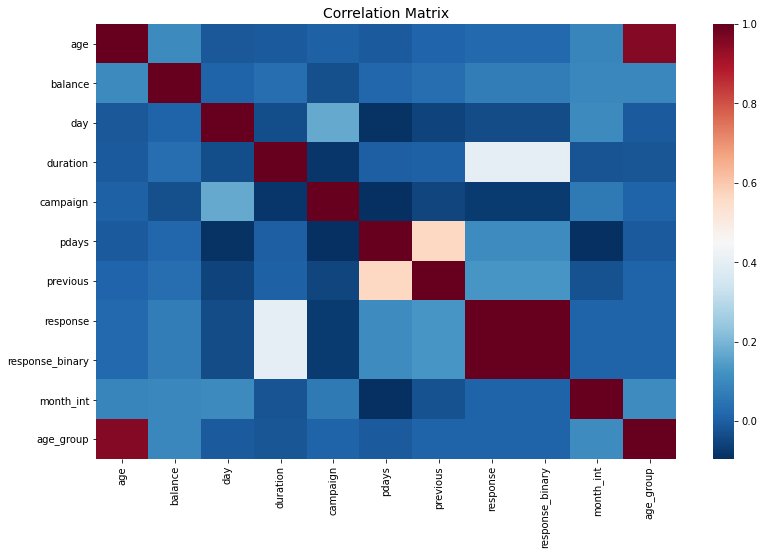

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
fig = plt.figure(figsize=(13, 8))
dataset['response'] = LabelEncoder().fit_transform(dataset['response'])
numeric_df = dataset.select_dtypes(exclude='object')
corr_numeric = numeric_df.corr()
plt.title("Correlation Matrix", fontsize=14)
sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.show()

#### Transform categorical data into dummy variables

The five categorical variables (job, education, default, housing, and loan) are transformed into dummy variables.  These dummy variables are used because categorical variables are not ordinal (numeric).  These variables represent different types rather than levels, so dummy variables are introduced to distinguish the effect of different categories.

In [5]:
dataset1= pd.get_dummies(dataset, columns=['job'])
dataset1['housing'] = dataset['housing'].map({'yes': 1, 'no': 0})
dataset1['default'] = dataset['default'].map({'yes': 1, 'no': 0})
dataset1['loan'] = dataset['loan'].map({'yes': 1, 'no': 0})
dataset_response = pd.DataFrame(dataset['response_binary'])
dataset1 = pd.merge(dataset1, dataset_response, left_index=True, right_index=True)

#### Feature Selection

The first 20 columns, which have the customer statistics, are selected as the features while the last column, 'campaign outcome', is the target.

In [6]:
array = dataset1.values
X = array[:, 0:-1]
Y = array[:, -1]

### Train/Test split

In [7]:
deposit = term_deposit['response']
term_deposit.drop(labels=['response'], axis=1, inplace=True)
term_deposit.insert(0, 'deposit', deposit)
term_deposit.head()
# Housing has a -20% correlation, how is it distributed?
term_deposit['housing'].value_counts() / len(term_deposit)

yes    0.558752
no     0.441248
Name: housing, dtype: float64

In [8]:
term_deposit['loan'].value_counts() / len(term_deposit)

no     0.833525
yes    0.166475
Name: loan, dtype: float64

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_set, test_set in stratified.split(term_deposit, term_deposit['loan']):
    stratified_train = term_deposit.loc[train_set]
    stratified_test = term_deposit.loc[test_set]
stratified_train['loan'].value_counts() / len(dataset1)
stratified_test['loan'].value_counts() / len(dataset1)

no     0.250067
yes    0.049950
Name: loan, dtype: float64

In [10]:
train_data = stratified_train
test_data = stratified_test
train_data.shape
test_data.shape
train_data['deposit'].value_counts()

no     25307
yes     3281
Name: deposit, dtype: int64

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64, handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown
        
    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' or ordinal, got %s")
            raise ValueError(template % self.handle.unknown)
        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or 'ignore', got %s")
            raise ValueError(template % self.handle.unknown)
        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown = 'ignore' is not supported for encoding='ordinal'")
        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape
        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]
        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.inid(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1} during fit".format(diff, i))
                        raise ValueError(msg)
                    le.classes_ = np.array(np.sort(self.categories[i]))
        self.categories_ = [le.classes_ for le in self._label_encoders_]
        return self
    
    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)
        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])
            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1} during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])
        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)
        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)
        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32), n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]
        out = sparse.csc_matrix((data, (row_indices, column_indices)), shape=(n_samples, indices[-1]), dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out
                    

In [27]:
# Class to select numerical or categorical columns since Scikit-Learn
# doesn't know how to handle dataframes
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [28]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28588 entries, 12071 to 39543
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   deposit          28588 non-null  object 
 1   age              28588 non-null  int64  
 2   job              28588 non-null  object 
 3   marital          28588 non-null  object 
 4   education        28588 non-null  object 
 5   default          28588 non-null  object 
 6   balance          28588 non-null  int64  
 7   housing          28588 non-null  object 
 8   loan             28588 non-null  object 
 9   day              28588 non-null  int64  
 10  month            28588 non-null  object 
 11  duration         28588 non-null  float64
 12  campaign         28588 non-null  int64  
 13  pdays            28588 non-null  int64  
 14  previous         28588 non-null  int64  
 15  poutcome         28588 non-null  object 
 16  response_binary  28588 non-null  int64  
 17  month_in

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
numerical_pipeline = Pipeline([("select_numeric", DataFrameSelector(['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'duration'])), ("std_scaler", StandardScaler())])
categorical_pipeline = Pipeline([("select_cat", DataFrameSelector(['job', 'education', 'marital', 'default', 'housing', 'loan', 'month', 'poutcome', 'age_group', 'balance_group'])), ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))])
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[("numeric_pipeline", numerical_pipeline), ("categorical_pipeline", categorical_pipeline),])

In [30]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-1.22887595, -0.50811904, -1.06447168, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.97099672, -0.31502968,  0.14042996, ...,  0.        ,
         1.        ,  0.        ],
       [-0.94193604, -0.4431708 , -0.94398152, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.36805621, -0.2489112 , -1.06447168, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.16229   , -0.53854525,  1.7068021 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.8462894 , -0.53386429,  1.22484144, ...,  0.        ,
         1.        ,  0.        ]])

In [31]:
y_train = train_data['deposit']
y_test = test_data['deposit']
y_train.shape

(28588,)

In [32]:
encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)
y_train_yes = (y_train == 1)
y_train
y_train_yes

array([False, False, False, ..., False, False, False])

In [33]:
some_instance = X_train[1250]

## Compare Classification Algorithms

Seven different classification algorithms (Logistical Regression, K-Neighbors Classifier, Ramdom Forest Classifier, GaussianNB, SVM, Graident Boosting, and Neural Network) are used on the dataset and the best scoring one will be used to build the model.

In [35]:
dict_classifiers = {
    'Logisitc Regression': LogisticRegression(),
    'Nearest Neighbors': KNeighborsClassifier(),
    'Linear SVM': SVC(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=10),
    'Neural Net': MLPClassifier(alpha=1),
    'Naive Bayes': GaussianNB()
}

In [36]:

num_classifiers = len(dict_classifiers.keys())
def batch_classify(X_train, Y_train, verbose=True):
    df_results = pd.DataFrame(data=np.zeros(shape=(num_classifiers, 2)), columns=['classifier', 'train_score'])
    count = 0
    for key, classifier in dict_classifiers.items():
        classifier.fit(X_train, Y_train)
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count, 'classifier'] = key
        df_results.loc[count, 'train score'] = train_score
        if verbose:
            print("trained {c}".format(c=key))
        count += 1
    return df_results

In [38]:
df_results = batch_classify(X_train, y_train)
print(df_results.sort_values(by='train_score', ascending=False))

trained Logisitc Regression
trained Nearest Neighbors
trained Linear SVM
trained Gradient Boosting Classifier
trained Random Forest
trained Neural Net
trained Naive Bayes
                     classifier  train_score  train score
0           Logisitc Regression          0.0     0.905170
1             Nearest Neighbors          0.0     0.923639
2                    Linear SVM          0.0     0.917378
3  Gradient Boosting Classifier          0.0     0.913600
4                 Random Forest          0.0     0.991920
5                    Neural Net          0.0     0.904470
6                   Naive Bayes          0.0     0.859102


In [41]:
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=3)
log_reg_mean = log_scores.mean()

svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
svc_mean = svc_scores.mean()

knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
knn_mean = knn_scores.mean()

grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
rand_mean = rand_scores.mean()

neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()

nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3)
nav_mean = nav_scores.mean()

d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Grad B CLF', 'Rand FC', 'Neural Classifer', 'Naive Bayes'],
    'Cross Validation Mean': [log_reg_mean, svc_mean, knn_mean, grad_mean, rand_mean, neural_mean, nav_mean]}
result_df = pd.DataFrame(data=d)

In [42]:
result_df = result_df.sort_values(by=['Cross Validation Mean'], ascending=False)
result_df


,Classifiers,Cross Validation Mean
3,Grad B CLF,0.906744
0,Logistic Reg.,0.904261
4,Rand FC,0.903386
1,SVC,0.903036
5,Neural Classifer,0.902896
2,KNN,0.896250
6,Naive Bayes,0.858647


#### Gradient Boosting is the best performing model.

The gradient boosting model has the highest score (0.906), suggesting a high level of strength of this model to classify the customer response given all of the features.

## Test GB model on test set

In [44]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)

In [45]:
grad_clf.fit(X_train, y_train)
print("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_train, y_train_pred))

Gradient Boost Classifier accuracy is 0.91


### Evaluate the model

Accuracy score is the percentage of correct predictions out of all of the predictions made.  This algorithm is 91% accurate, suggesting this model is very strong to classify the customer response given all of the defined customer features.

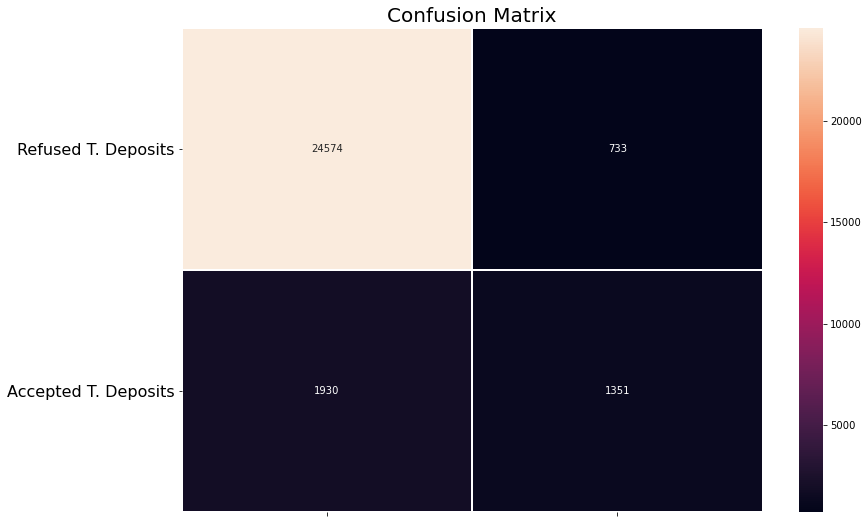

In [46]:
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show()

## Precision vs. Recall
<b>Precision</b>: The total number of "Yes" in the label column of the dataset.  How many "Yes" labels does this model detect?
<b>Recall</b>: How sure is the prediction of our model that the actual label is "Yes".

In [48]:
from sklearn.metrics import precision_score, recall_score
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))

Precision Score:  0.6482725527831094
Recall Score:  0.4117647058823529


<b> Recall-Precision Tradeoff</b>:<br/>
As the precision gets higher, the recall decreases and vice versa.  For example, if we increase the precision from 30% to 60%, our model is picking the predictions that the model thinks is 60% sure.  The higher the precision score, the more likely that the model is to miss instances that were actually "Yes" versus those that were "No".

In [49]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.5036346691519106

In [50]:
y_scores = grad_clf.decision_function([some_instance])
y_scores

array([-2.20301148])

In [51]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [60]:
y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=3, method='decision_function')
log_scores = cross_val_predict(log_reg, X_train, y_train, cv=3, method='predict_proba')
rand_y_scores = cross_val_predict(rand_clf, X_train, y_train, cv=3, method='predict_proba')

In [62]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
if log_scores.ndim == 2:
    log_scores = log_scores[:, 1]
if rand_y_scores.ndim == 2:
    rand_y_scores = rand_y_scores[:, 1]

In [63]:
y_scores.shape

(28588,)

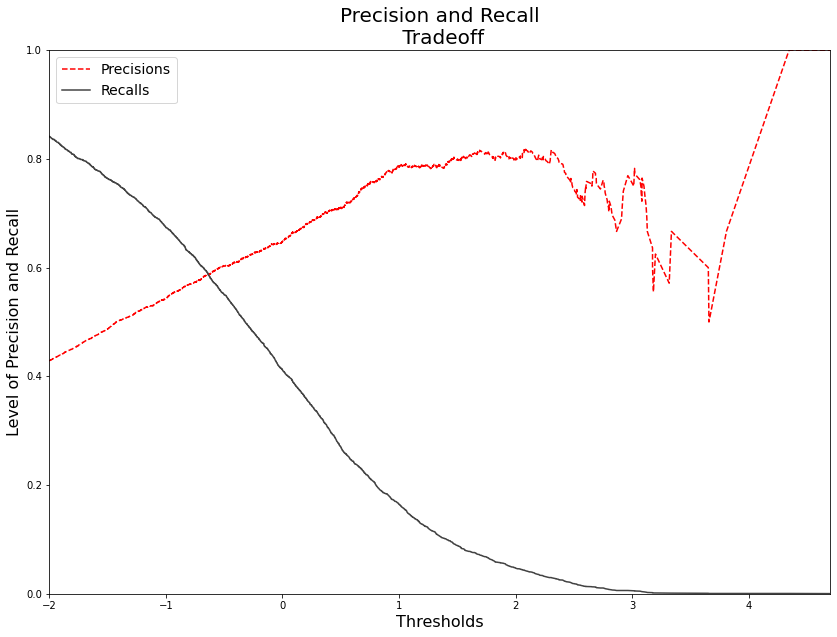

In [64]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)
fig, ax = plt.subplots(figsize=(14, 10))
plt.plot(threshold, precisions[:-1], "r--", label="Precisions")
plt.plot(threshold, recalls[:-1], "#424242", label="Recalls")
plt.title("Precision and Recall\n Tradeoff", fontsize=20)
plt.ylabel("Level of Precision and Recall", fontsize=16)
plt.xlabel("Thresholds", fontsize=16)
plt.legend(loc='best', fontsize=14)
plt.xlim([-2, 4.7])
plt.ylim([0, 1])
plt.show()

## ROC Curve

THe ROC curve tells how well our classifier is classifying between the True Positives and the non-term deposit subscriptions (FP).  The X-axis is the specificity and the Y-axis is the sensitivity.  The closer the line is to the top left corner, the better our model is at separating both classes.

In [ ]:
from sklearn.metrics import mean_squared_error
print('The mean squared error is: ', mean_squared_error(y_test, predicted_y))

In [66]:
from sklearn.metrics import roc_curve
# Gradient boosting classifier
# Logistic Regression
# Random Forest
grd_fpr, grd_tpr, threshold = roc_curve(y_train, y_scores)
log_fpr, log_tpr, log_threshold = roc_curve(y_train, log_scores)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_train, rand_y_scores)

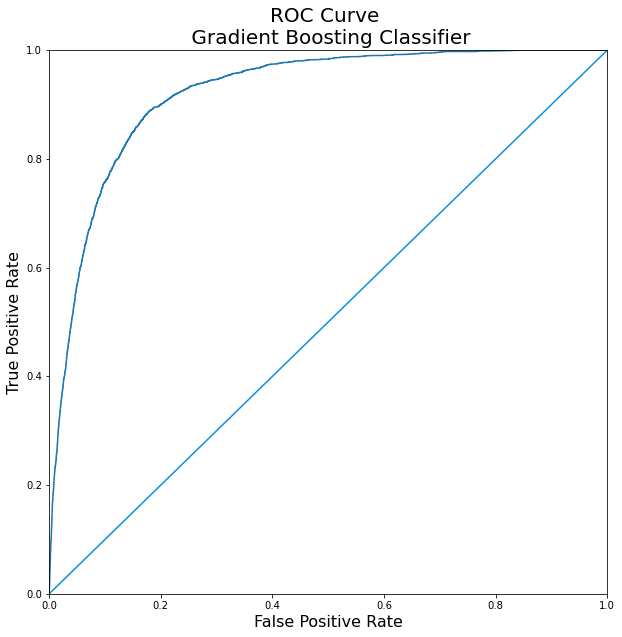

In [68]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10, 10))
    plt.title("ROC Curve \n Gradient Boosting Classifier", fontsize=20)
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0,1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    
graph_roc_curve(grd_fpr, grd_tpr, threshold)
plt.show()

In [69]:
print('Gradient Boost Classifier Score: ', roc_auc_score(y_train, y_scores))
print('Logistic Regression Classifier Score: ', roc_auc_score(y_train, log_scores))
print('Random Forest Classifier Score: ', roc_auc_score(y_train, rand_y_scores))

Gradient Boost Classifier Score:  0.9208240153192494
Logistic Regression Classifier Score:  0.9099413364204545
Random Forest Classifier Score:  0.8994066788517288


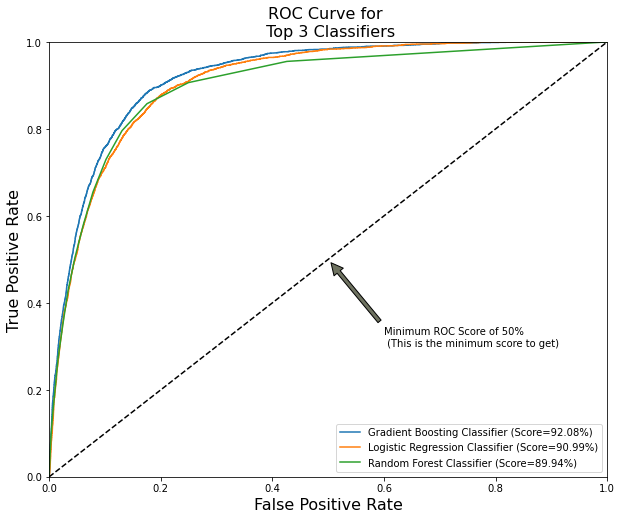

In [70]:
def graph_roc_curve_multiple(grd_fpr, grd_tpr, log_fpr, log_tpr, rf_fpr, rf_tpr):
    plt.figure(figsize=(10, 8))
    plt.title('ROC Curve for \n Top 3 Classifiers', fontsize=16)
    plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier (Score=92.08%)')
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier (Score=90.99%)')
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (Score=89.94%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3), arrowprops = dict(facecolor='#6E7260', shrink=0.05), )
    plt.legend()
    
graph_roc_curve_multiple(grd_fpr, grd_tpr, log_fpr, log_tpr, rf_fpr, rf_tpr)
plt.show()

In [71]:
grad_clf.predict_proba([some_instance])

array([[0.90051962, 0.09948038]])

In [72]:
grad_clf.predict([some_instance])

array([0])

In [73]:
y_train[1250]

1